# Vaje 8: Nevronske mreže 2

## Naloga 1: Samokodirniki

Naloga samokodirnikov je podatke "stisnit" oz vpet (to boste kasneje delali na predavanjih) v prostor nižje dimenzije (imenovan tudi latentni prostor). Podatke tako preslikajo v latentni prostor in nazaj v originalen prostor. Pri tem je cilj, da se originalni podatki in rekonstruirani podatki čim bolj skladajo (oz. imamo nizko rekonstrukcijsko napako).

Poglejmo si primer samokodirnika na primeru od zadnjič; slikah ročno napisanih števk.

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transform
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
train_set = MNIST('../Podatki/', train=True, download=True, 
                  transform=transform.Compose([transform.ToTensor(), transform.Normalize((0.1307,), (0.3081,))]))

# Naložimo testno množico, slike pretvorimo v tenzorje in jih standardiziramo
test_set = MNIST('../Podatki/', train=False, download=True, 
                 transform=transform.Compose([transform.ToTensor(), transform.Normalize((0.1307,), (0.3081,))]))

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

1.a: Dopolni nevronski mreži `Encoder` (kodirnik) in `Decoder` (dekodirnik). Kodirnik bo sliko zakodiral v latentni prostor, Dekodirnik pa bo sliko dekodiral iz latentnega prostora nazaj v originalen prostor (prostor slik).

Kodirnik naj vsebuje tri konvolucijske sloje (s 8, 16 in 32 izhodnih kanalov, konvolucijskim jedrom 3, stride 2 in prva dva padding 1, zadnji 0) in dva polno povezana sloja (prvi z vhodno dimenzijo 3*3*32 in izhodno dimenzijo 128 in drugi z izhodno dimenzijo `latent_dimension`). Kjer je smiselno dodaj aktivacijsko funkcijo ReLu, takoj za drugim konvolucijskim slojem BatchNorm2d sloj (s parametrom 16) in pred prvim polno-povezanim slojem ne pozabim slike spremeniti v vektor (uporabi parameter start_dim=1)

Dekodirnik naj vsebuje iste sloje, a v obratni smeri. Tu namesto Conv2D uporabi ConvTranspose2d in poleg parametra padding nastavi še parameter output_padding (na isto vrednost). Za drugim polno-povezanim slojem vektor pretvori v slike z nn.Unflatten (dim=1, unflattened_size=(32, 3, 3)).

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dimension)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        return x
    
# V dekodirniku moramo poleg vrstnega reda sloja, obrniti tudi vhodno in izhodno dimenzijo
class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super().__init__()
        self.decoder_cnn = nn.Sequential(
            nn.Linear(latent_dimension, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=0, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )
        
    def forward(self, x):
        x = self.decoder_cnn(x)
        return torch.sigmoid(x)

Modela natreniraj. To lahko traja nekaj minut.

In [4]:
loss_fn = torch.nn.MSELoss()

lr= 0.001

torch.manual_seed(0)

encoder = Encoder(latent_dimension=5)
decoder = Decoder(latent_dimension=5)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

num_epochs = 20
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in train_loader:
        # Pošljemo slike čez kodirnik
        encoded_data = encoder(image_batch)
        # Zakodirane slike pošljemo čez dekodirnik
        decoded_data = decoder(encoded_data)
        # Primerjamo začetne slike z rekonstruiranimi slikami
        loss = loss_fn(decoded_data, image_batch)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss.append(loss.detach().cpu().numpy())
    print(f"Epoch {epoch}, loss: {np.mean(train_loss)}")

Epoch 0, loss: 0.7844856977462769
Epoch 1, loss: 0.5826449990272522
Epoch 2, loss: 0.569636344909668
Epoch 3, loss: 0.5646849870681763
Epoch 4, loss: 0.5616450905799866
Epoch 5, loss: 0.5594366788864136
Epoch 6, loss: 0.5578734278678894
Epoch 7, loss: 0.5563622117042542
Epoch 8, loss: 0.5549909472465515
Epoch 9, loss: 0.554063618183136
Epoch 10, loss: 0.553135871887207
Epoch 11, loss: 0.5522384643554688
Epoch 12, loss: 0.5515171885490417
Epoch 13, loss: 0.5508490800857544
Epoch 14, loss: 0.5502161979675293
Epoch 15, loss: 0.5497514605522156
Epoch 16, loss: 0.549167275428772
Epoch 17, loss: 0.5488385558128357
Epoch 18, loss: 0.5484914183616638
Epoch 19, loss: 0.547976553440094


1.b: Poglejmo si kako dobro model slike rekonstruira. V spodnji kodi dopolni vrstico, s katero dobimo rekonstruirano sliko.

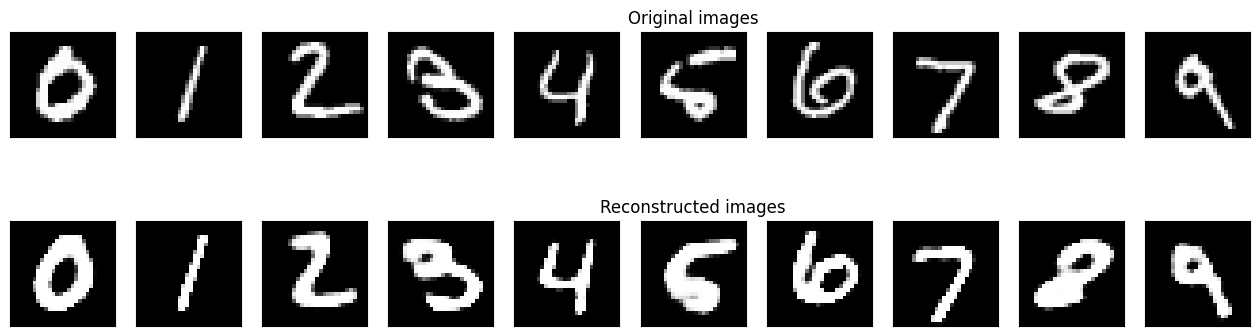

In [5]:
plt.figure(figsize=(16,4.5))
targets = test_set.targets.numpy()
t_idx = {i: np.where(targets==i)[0][0] for i in range(10)}

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    img = test_set[t_idx[i]][0].unsqueeze(0)
    encoder.eval()
    decoder.eval()
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if i == 5:
        ax.set_title('Original images')
    ax = plt.subplot(2, 10, i + 11)
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if i == 5:
        ax.set_title('Reconstructed images')
plt.show()   

1.c: Poglejmo si še, kako se slike gručijo oz. kam v latentni prostor se preslikajo. Dopolni vrstico, v kateri sliko zakodiraš v latentni prostor. 

In [6]:
encoded_samples = []
for sample in test_set:
    img = sample[0].unsqueeze(0)
    label = sample[1]
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

Z uporabo metode TSNE lahko podatke (nelinearno) preslikamo v še nižjo dimenzijo in jih tako vizualiziramo. Kaj lahko opaziš na spodnjih slikah in ali si to pričakoval?

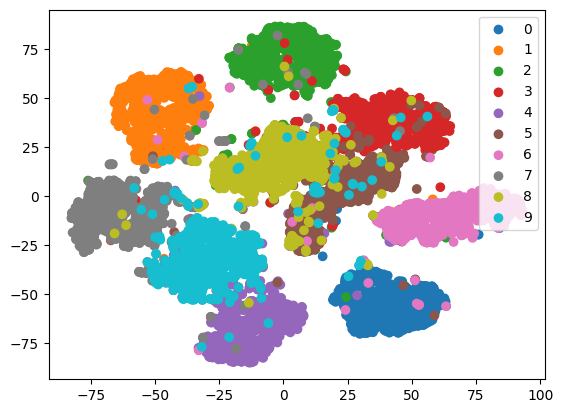

In [7]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
labels = encoded_samples["label"].to_numpy()

for i in range(10):
    indices = labels == i
    fig = plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=[plt.get_cmap("tab10").colors[i] for j in range(np.sum(indices))], label=i)

plt.legend()
plt.show()

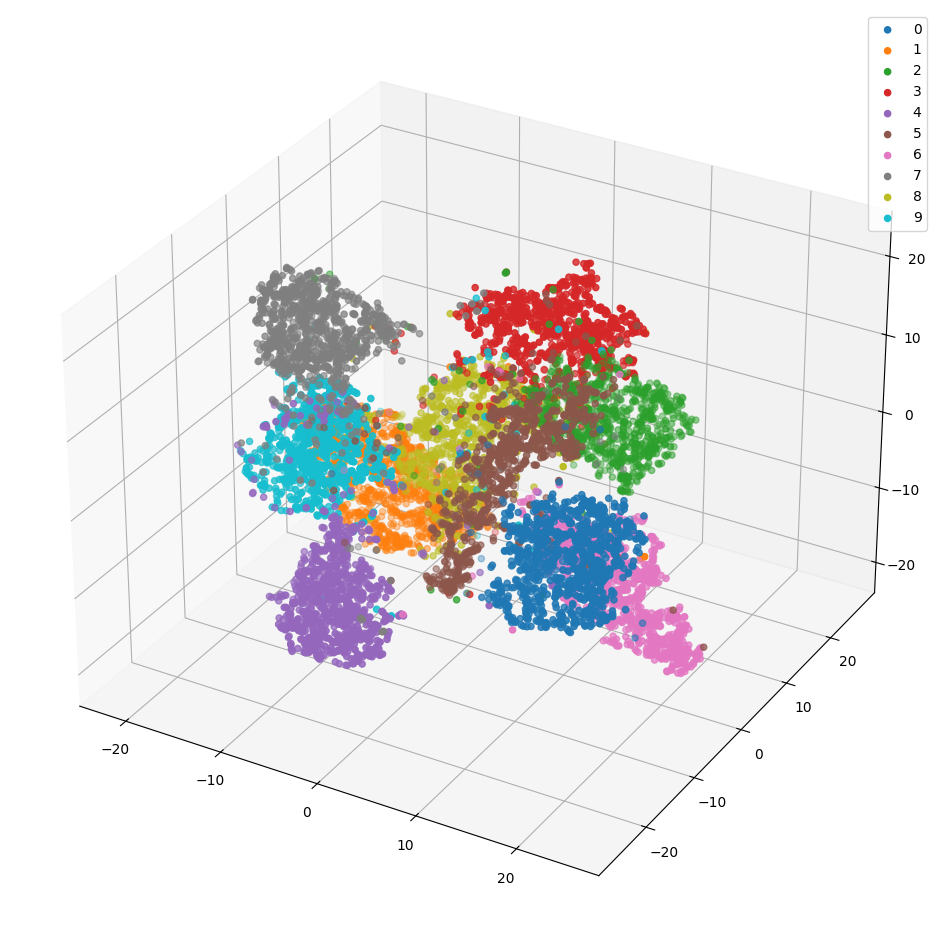

In [8]:
tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
labels = encoded_samples["label"].to_numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for i in range(10):
    indices = labels == i
    fig = ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], tsne_results[indices, 2], c=[plt.get_cmap("tab10").colors[i] for j in range(np.sum(indices))], label=i)

plt.legend()
plt.show()


1.d: Vidimo lahko torej, da so podatki z isto cilno vrednostjo, pogosto preslikani blizu v latentnem prostoru. S preslikanimi podatki si torej lahko pomagamo pri klasifikaciji. S spodnjo kodo podatke zakodiramo v latentni prostor in jih spremenimo v numpy array. Na podoben način pripravi testno množico in na njej preveri točnost napovednega modela SVM (SVC v sklearn-u) naučenega na učni množici

In [9]:
train_x = []
train_y = []

for sample in train_set:
    img = sample[0].unsqueeze(0)
    train_y.append(sample[1])
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    train_x.append(encoded_img.flatten().cpu().numpy())

train_x = np.array(train_x)
train_y = np.array(train_y)

In [10]:
test_x = []
test_y = []

for sample in test_set:
    img = sample[0].unsqueeze(0)
    test_y.append(sample[1])
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    test_x.append(encoded_img.flatten().cpu().numpy())

test_x = np.array(test_x)
test_y = np.array(test_y)

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [12]:
kfold = KFold(shuffle=True)
accuracies = []

for i, (train_idx, test_idx) in enumerate(kfold.split(train_x)):
    x_train = train_x[train_idx]
    y_train = train_y[train_idx]
    x_test = train_x[test_idx]
    y_test = train_y[test_idx]
    model = SVC(kernel="linear").fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Fold {i}: accuracy {accuracy}")
    accuracies.append(accuracy)

print(np.mean(accuracies))

model = SVC(kernel="linear").fit(train_x, train_y)
y_pred = model.predict(test_x)
accuracy = accuracy_score(test_y, y_pred)

Fold 0: accuracy 0.9349166666666666
Fold 1: accuracy 0.93525
Fold 2: accuracy 0.9365
Fold 3: accuracy 0.9355
Fold 4: accuracy 0.9363333333333334
0.9357000000000001


## Naloga 2: Rekurenčne nevronske mreže (GRU) 

2.a: Dopolni funkcijo `create_sequences`, ki sprejme časovno vrsto dolžine N ter parameter M (seq_length) in zgenerira N-M zaporedij dolžine M (torej prvo od indeksa 0 do indeksa M, drugo od 1 do M+1, itd.). Seznam sequences naj na koncu vsebuje 2-terice zaporedje, ciljna vrednost (naslednja vrednost v zaporedju).

In [13]:
from torch.utils.data import TensorDataset

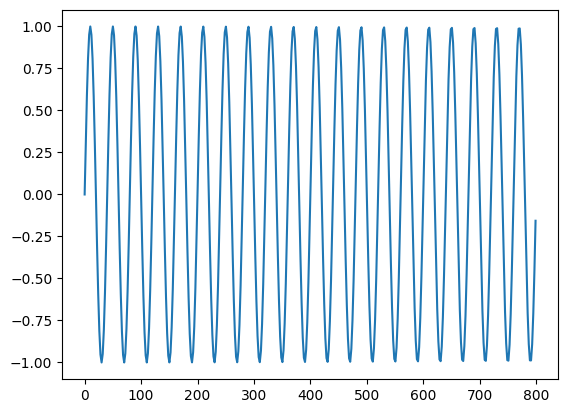

In [14]:
x = torch.linspace(0,799,400)
y = torch.sin(x*2*np.pi/40) 

test_size = 100
train_data = y[:-test_size]
test_data = y[-test_size:]

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        sequences.append((data[i:i+seq_length], data[i+seq_length:i+seq_length+1]))
    return sequences

seq_length = 20
train_sequences = create_sequences(train_data, seq_length)

plt.plot(x,y)

2.a: Dopolni spodnjo kodo, ki definira [GRU celico](https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html)

In [15]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        # Definiramo potrebne sloje, na par matrike W in vektorja b iz formul lahko gledamo kot na polno-povezan sloj
        self.rx = nn.Linear(input_size, hidden_size)
        self.rh = nn.Linear(hidden_size, hidden_size)
        self.zx = nn.Linear(input_size, hidden_size)
        self.zh = nn.Linear(hidden_size, hidden_size)
        self.nx = nn.Linear(input_size, hidden_size)
        self.nh = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)


    def forward(self, X):
        output = []
        h = torch.zeros(self.hidden_size)
        for t in range(X.shape[0]):
            x = X[t].view(-1)
            # Podatke pošljemo čez polno-povezane sloje in jih obdelamo po formulah za GRU
            r = torch.sigmoid(self.rx(x) + self.rh(h))
            z = torch.sigmoid(self.zx(x) + self.zh(h))
            n = torch.tanh(self.nx(x) + r * self.nh(h))
            h = (1 - z) * n + z * h
            output += [self.output_layer(h)]

        output = torch.stack(output)
        return output[-1]

Model natreniraj in potestiraj na testnih podatkih

In [16]:
model = GRU(1, 10, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

epochs = 10
for epoch in range(epochs):
    print("Epoch ", epoch)
    total_loss = 0
    for i, (seq, labels) in enumerate(train_sequences):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()
    print(f"Loss {total_loss/len(train_sequences)}")



Epoch  0


Loss 0.7205293096949846
Epoch  1
Loss 0.7175831202943188
Epoch  2
Loss 0.7146658368742856
Epoch  3
Loss 0.7117671605999342
Epoch  4
Loss 0.708884955810966
Epoch  5
Loss 0.706018461715689
Epoch  6
Loss 0.703167141367059
Epoch  7
Loss 0.700330445831174
Epoch  8
Loss 0.6975081510814473
Epoch  9
Loss 0.6946998620878434


-1.1511652027719625


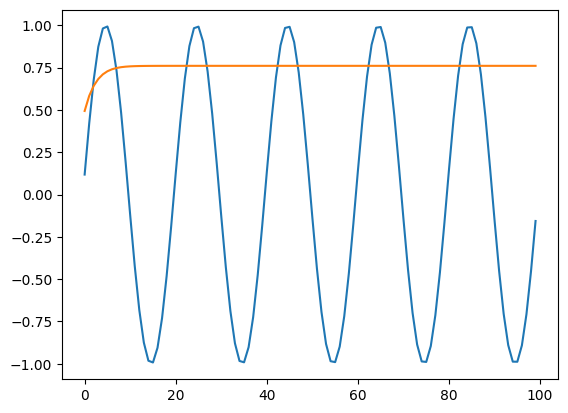

In [17]:
test_inputs = train_data[-seq_length:].tolist()
model = model.eval()
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    with torch.no_grad():
        res = model(seq)
        test_inputs.append(res.item())

from sklearn.metrics import r2_score
print(r2_score(test_data.numpy(), test_inputs[seq_length:]))

actual_predictions = test_inputs[seq_length:]
plt.plot(y.data.numpy()[-test_size:])
plt.plot(actual_predictions)
plt.show()

2.c: Poišči vrednosti parametrov "learning_rate" in "hidden_size" pri katerih bo model dobro deloval.

Epoch  0
Loss 0.3746369043509469
Epoch  1
Loss 0.19994556597706686
Epoch  2
Loss 0.09754245860538374
Epoch  3
Loss 0.041765737577422815
Epoch  4
Loss 0.014916418115617652
Epoch  5
Loss 0.004942269707427727
Epoch  6
Loss 0.0024786498428033582
Epoch  7
Loss 0.001953985331987302
Epoch  8
Loss 0.0017166100788651407
Epoch  9
Loss 0.0015255446203104356
0.9959270304110572


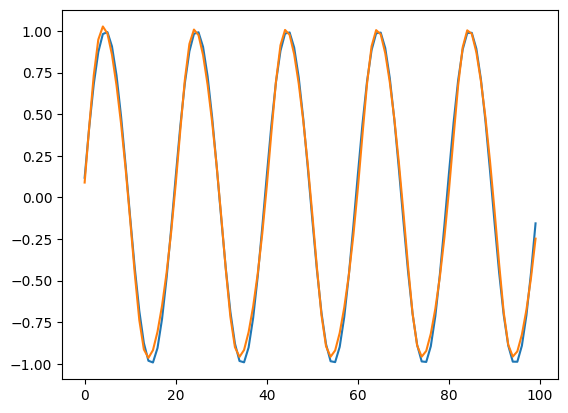

In [18]:
model = GRU(1, 32, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 10
for epoch in range(epochs):
    print("Epoch ", epoch)
    total_loss = 0
    for i, (seq, labels) in enumerate(train_sequences):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()
    print(f"Loss {total_loss/len(train_sequences)}")

test_inputs = train_data[-seq_length:].tolist()
model = model.eval()
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    with torch.no_grad():
        res = model(seq)
        test_inputs.append(res.item())

from sklearn.metrics import r2_score
print(r2_score(test_data.numpy(), test_inputs[seq_length:]))

actual_predictions = test_inputs[seq_length:]
plt.plot(y.data.numpy()[-test_size:])
plt.plot(actual_predictions)
plt.show()


2.d: Na podoben način sestavi novo podatkovno množico za časovno vrsto, ki je definirana s funkcijo $0.5\cdot\sin (2\cdot x\cdot\pi /40)+ \sin (2\cdot x\cdot\pi /400)$. Najdi model, ki bo tudi na teh podatkih dobro deloval. Pomagaš si lahko tako, da združiš več GRU celic ali pa sestaviš "močnejšo" LSTM celico.

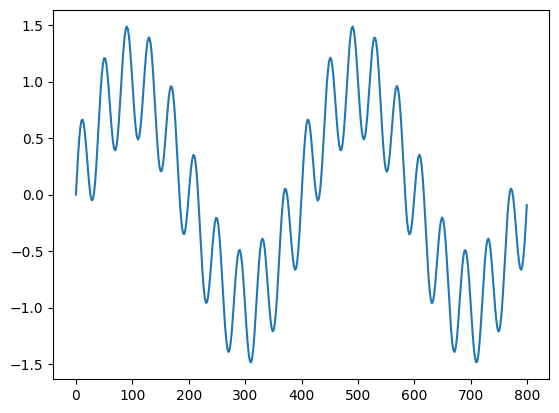

In [19]:
x = torch.linspace(0,799,400)
y = 0.5*torch.sin(x*2*np.pi/40) + torch.sin(x*2*np.pi/400)

plt.plot(x,y)